# INFO 2950 Final Project 

## __Fund Investment Decisions: Mutual Funds or Exchange Traded Funds?__

By Cameron Robinson (ctr48) , David Vilensky (dlv46) , Cassandra Kaufman (cpk57) , and Emily Sobel (es983)

## Introduction

A central pillar of the global economy is _investment_: the process of sacrificing present assets in order to get returns on those assets in the future. There are many different types of investments and investing can be dated all the way back to the 16th century. Hundreds of years later a strategy of investment emerged  in 18th century France: the idea of pooling assets together from various sources with the intent of collectively investing. 

These investment funds first emerged in the United States in the form of __Mutual Funds__, funds that are actively managed by a fund manager who uses the assets within the fund to generate returns for the fund shareholders. Because these funds need management in order to generate returns, there is a fee involved in joining them. The fund investment vehicle that later emerged to challenge Mutual Funds are __Exchange Traded Funds or ETFs__. In direct contrast with Mutual Funds, ETFs are passively managed -- they track a specific market index. With ETFs investors hope to capture the returns of the market on the whole, and not wasting the resources required to actively manage a fund.       

The question of wether the active management style of Mutual Funds can outperform the market and the passive investment style of ETFs has been debated by investors and the answer still remains unclear. In this project we hope to explore this question.

-----------------------------------------------------------------------------------------------
 

 __Research Question:__

What set of criteria is most important to the sucess of a mutual fund? What about amongst ETFs? Which type of fund is more successful overall can can the success of a fund be accurately predicted based on these observed criteria?

---------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Importing

In [1]:
# imports and settings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import chi2_contingency
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import re

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('seaborn-poster')

## Data Overview



The file contains 24,821 Mutual Funds and 1,680 ETFs with general aspects (as Total Net Assets, management company and size), portfolio indicators (as cash, stocks, bonds, and sectors), returns (as yeartodate, 2020-11) and financial ratios (as price/earning, Treynor and Sharpe ratios, alpha, and beta). This data was scraped from Yahoo Finance by kaggle user Stefano Leone.

Link to dataset: https://www.kaggle.com/stefanoleone992/mutual-funds-and-etfs


__Exchange Traded Funds Dataset: 'ETFs.csv'__


In [2]:
df_etf=pd.read_csv('USData/ETFs.csv')

__Mutual Funds Dataset: 'Mutual Funds.csv'__

In [3]:
df_mf=pd.read_csv('USData/Mutual Funds.csv')

/Users/caseykaufman/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (167,171) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Data Description

The two datasets used were created to allow for multiple comparisons regarding portfolio decisions from investment managers in Mutual Funds and portfolio restrictions to the indexes in Exchnage traded funds. Each of the datasets are composed of publicly available information and were not funded by any companies or private organizations. The instances in each of the datasets are  funds with the respective fund type, either Exchange traded funds in the ETF.csv or Mutual funds in the Mutual Funds.csv. The columns in each of the datasets contain information on the respective fund's financial ratios, sector investments, risk ratios, and returns. The data in each of the datasets was collected over a time period between 2011 and 2020. The original datasets don't have any errors but they do contain null information in the form of empty columns that were dropped during our data cleaning. This preprocessing and all other preprocessing of the data found in the two datasets is extensively documented in our data cleaning section and we have made no additional modifications or alterations to the data. The creator of the datasets placed no copyrights or restrictions on their use and under its license of CC0: Public Domain, we have permission to access and use its both of the datsets content for our project. 
 

## Data Cleaning

Since our datasets are rather large, we created a method that allowed us to break down and sort either dataset based off keywords in column names : 

In [4]:
### Creates and returns a subset of df_mf by keeping only the columns with 'keyword' in their column name. 
def cleanbykeyword(df,keyword):
    """
    Searches and creates a list of all of the column names in df that contain the keyword.
    Subsets the df according to this list, then creates a df_new dataframe with this 
    information and drops the corresponding columns from the original df.

    Arguments:
        df: Dataset pandas DataFrame.
        cols: List of columns to be included in calculations. 
        keyword: Word to be removed from column name in order to preserve clarity with labeling.
        
        
    Return: dataframe containing data matching keyword.
    """
    col_list=[ i for i in df.columns if (keyword in i)] 
    #print(col_list)
    df_new=df[col_list]
    df.drop(columns=col_list,axis=1,inplace=True) #removes duplicate data from df_mf masterframe
    df_new.insert(0,'fund_symbol',df.fund_symbol) #inserts the fund symbols as the 1st column of the new data set
    return (df_new)

Throwing away empty columns and columns not used in our analysis: 

In [5]:
empty_cols2 = [col for col in df_etf.columns if df_etf[col].isnull().all()]
df_etf.drop(empty_cols2,axis=1,inplace=True)

throwaway_cols=[
    'quarters_up',
    'quarters_down',
    'top10_holdings',
    'years_up',
    'years_down',
    'currency'
]
df_mf.drop(columns=throwaway_cols,axis=1,inplace=True)
df_etf.drop(columns=throwaway_cols[2:],axis=1,inplace=True)

df_etf.to_csv('NoEmptiesETFs.csv',index=False)
df_mf.to_csv('NoEmptiesMutual Funds.csv',index=False)



Removing category data from the dataframe. Some of the category columns were not updated properly in the data set and therefore cannot be used in our analyses, we drop them to save space:

In [6]:
df_mf_category_data=cleanbykeyword(df_mf,'category_')
df_etf_category_data=cleanbykeyword(df_etf,'category_')

Transforms treynor ratio columns to floats and saves partially cleaned dataframes for more efficient use in the future. 

In [7]:
def str_to_float(df,column):
    '''
    This method converts the values of a specific column in a given dataframe from strings to floats\n",
    '''
    list=[]
    col=df.columns.get_loc(column)
    for i in range(df.shape[0]):
        treynor=df.iloc[i,col]
        if type(treynor) == None:
            list.append(-1)
        if type(treynor) != None:
            if type(treynor) == str:
                treynor = treynor.replace(',','')
            f=float(treynor)
            list.append(f)
    return(list)
   


In [8]:
#converting treynor columns from strings to floats ETF 
df_mf['fund_treynor_ratio_3years'] = str_to_float(df_mf,'fund_treynor_ratio_3years')
df_mf['fund_treynor_ratio_5years'] = str_to_float(df_mf,'fund_treynor_ratio_5years')
df_mf['fund_treynor_ratio_10years'] = str_to_float(df_mf,'fund_treynor_ratio_10years')

#converting treynor columns from strings to floats MUTUAL FUNDS  
df_etf['fund_treynor_ratio_3years'] = str_to_float(df_etf,'fund_treynor_ratio_3years')
df_etf['fund_treynor_ratio_5years'] = str_to_float(df_etf,'fund_treynor_ratio_5years')
df_etf['fund_treynor_ratio_10years'] = str_to_float(df_etf,'fund_treynor_ratio_10years')


Saves category fund return ytd in a new col and saves new df for future use 

In [9]:
df_mf['category_return_ytd']=df_mf_category_data['category_return_ytd']
df_etf['category_return_ytd']=df_etf_category_data['category_return_ytd']

#Saves new dataframes for future use.
df_mf2=df_mf3=df_mf.copy()
df_etf2=df_etf3=df_etf.copy()

__Using our clean by keyword method to break the dataframe into more easily accessible parts:__

In [10]:
#standard deviation
df_mf_standard_deviations= cleanbykeyword(df_mf,'standard_deviation')
df_etf_standard_deviations=cleanbykeyword(df_etf,'standard_deviation')

df_etf_standard_deviations.to_csv('stdsETFs.csv',index=False)
df_mf_standard_deviations.to_csv('stdsMutual Funds.csv',index=False)

#sector
df_mf_sector=cleanbykeyword(df_mf,'sector')
df_etf_sector=cleanbykeyword(df_etf,'sector')

df_etf_sector.to_csv('sectorsETFs.csv',index=False)
df_mf_sector.to_csv('sectorsMutual Funds.csv',index=False)

#ratios
df_mf_ratios=cleanbykeyword(df_mf,'_ratio')
df_etf_ratios=cleanbykeyword(df_etf,'_ratio')

df_etf_ratios.to_csv('ratiosETFs.csv',index=False)
df_mf_ratios.to_csv('ratiosMutual Funds.csv',index=False)
                    
#alpha & beta 
df_mf_alpha=cleanbykeyword(df_mf,'alpha')
df_etf_alpha=cleanbykeyword(df_etf,'alpha')

df_mf_beta=cleanbykeyword(df_mf,'beta')
df_etf_beta=cleanbykeyword(df_etf,'beta')
                    
#credit
df_mf_credit=cleanbykeyword(df_mf,'credit').dropna()
df_etf_credit=cleanbykeyword(df_etf,'credit').dropna()
df_mf_credit.to_csv('creditsMutual Funds.csv',index=False)

#R squared
df_mf_rsquare=cleanbykeyword(df_mf,'squared')
df_etf_rsquare=cleanbykeyword(df_etf,'squared')

#assets
df_mf_asset=cleanbykeyword(df_mf,'asset')
df_etf_asset=cleanbykeyword(df_etf,'asset')

df_etf_asset.to_csv('assetsETFs.csv',index=False)
df_mf_asset.to_csv('assetsMutual Funds.csv',index=False)\
                    
#fund return
df_mf_return_history=cleanbykeyword(df_mf,'_return_')
df_etf_return_history=cleanbykeyword(df_etf,'_return_').dropna()

df_etf_return_history.to_csv('returnsETFs.csv',index=False)
df_mf_return_history.to_csv('returnsMutual Funds.csv',index=False)

    #Adds fund_return_ytd column to main datafrme and removes from return history subframe
df_mf['fund_return_ytd']=df_mf_return_history['fund_return_ytd']
df_etf['fund_return_ytd']=df_etf_return_history['fund_return_ytd']
df_mf_return_history=df_mf_return_history.drop(columns=['fund_return_ytd'])
df_etf_return_history=df_etf_return_history.drop(columns=['fund_return_ytd'])
    
#Removing quarterly data from return history
#cleanbykeyword(df_mf_return_history,'_q')
#cleanbykeyword(df_etf_return_history,'_q')

#merging datasets containing R-Squares, Alpha, and Beta values into a single data set:
df_mf_stats=df_mf_rsquare.merge(df_mf_alpha,how='left')
df_mf_stats=df_mf_stats.merge(df_mf_beta,how='left')
df_mf_stats.to_csv('statsMutual Funds.csv',index=False)
df_mf_stats.head()

df_etf_stats=df_etf_rsquare.merge(df_etf_alpha,how='left')
df_etf_stats=df_etf_stats.merge(df_etf_beta,how='left')
df_etf_stats.to_csv('statsETFs.csv',index=False)


# Methods Used Section

Methods used for data exploration:

In [11]:
def comparison_pies(df1,df2,column,t1,t2):
   
    y=df1.groupby(column).fund_symbol.count()
    x=df2.groupby(column).fund_symbol.count()

    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.pie(y,labels=y.index.to_numpy(),autopct='%.2f%%')
    ax2.pie(x,labels=x.index.to_numpy(),autopct='%.2f%%')
    
    ax1.set_title (t1)
    ax2.set_title (t2)
    plt.tight_layout()

In [12]:
#creates a pie chart representing the relative distribution of funds in a certain category 
def pie_chart(df,column):
    '''
    Param df: Pandas dataframe
    Param column: column in df that is to be analyzed.
    '''
    grouped=df.groupby(column).fund_symbol.count().to_frame()
    plt.pie(grouped.fund_symbol,labels=grouped.index,autopct='%.2f%%')
    plt.show()


In [13]:
#creats a pie chart representing the % composition of a certain range of values in a dataset.
def multiple_percent_comp_bar(df,df2,cols,cols2,keyword,t1,t2):
    """
    Creates a pie chart for a given DataFrame subset. Each section in the pie chart
    represents a column mean within the dataframe, which corresponds to a % invested
    in a given category (sector/asset)
    
    Arguments:
        df: Dataset pandas DataFrame.
        cols: List of columns to be included in calculations. 
        keyword: Word to be removed from column name in order to preserve clarity with labeling.
    """
    
    
    fig, (ax1, ax2) = plt.subplots(1,2)
        
        
    col_names=[]
    other=0
    col_sums=[]
    for column in cols:
        col_sum=df[column].mean()
        if(col_sum<1 or 'other' in column):
            other+=col_sum
        else:
            col_names.append(column.replace(keyword,''))
            col_sums.append(df[column].mean())
    if(other>0.1):
        col_names.append('other')
        col_sums.append(other)
    ax1.pie(col_sums,labels=col_names,autopct='%.2f%%') 
    ax1.set_title (t1)
   

    
    col_names2=[]
    other2=0
    col_sums2=[]
    for column in cols2:
        col_sum=df2[column].mean()
        if(col_sum<1 or 'other' in column):
            other+=col_sum
        else:
            col_names2.append(column.replace(keyword,''))
            col_sums2.append(df2[column].mean())
    if(other>0.1):
        col_names2.append('other')
        col_sums2.append(other)
    ax2.pie(col_sums2,labels=col_names2,autopct='%.2f%%') 
    ax2.set_title (t2)

    plt.tight_layout()
    plt.show()



In [14]:
#creats a pie chart representing the % composition of a certain range of values in a dataset.
def percent_comp_bar(df,cols,keyword):
    """
    Creates a pie chart for a given DataFrame subset. Each section in the pie chart
    represents a column mean within the dataframe, which corresponds to a % invested
    in a given category (sector/asset)
    
    Arguments:
        df: Dataset pandas DataFrame.
        cols: List of columns to be included in calculations. 
        keyword: Word to be removed from column name in order to preserve clarity with labeling.
    """
    col_names=[]
    other=0
    col_sums=[]
    for column in cols:
        col_sum=df[column].mean()
        if(col_sum<1 or 'other' in column):
            other+=col_sum
        else:
            col_names.append(column.replace(keyword,''))
            col_sums.append(df[column].mean())
    if(other>0.1):
        col_names.append('other')
        col_sums.append(other)
    plt.pie(col_sums,labels=col_names,autopct='%.2f%%') 
    plt.show()


In [15]:
#Draws a boxplot representing the dependent column as a function of the independent column
def dep_by_indep_boxplot(df_joined,independent,dependent,fundtype):
    '''
    Param df_joined: dataframe containing both the independent and dependent columns
    Param independent: column which serves as the independent variable
    Param dependent: column which serves as the dependent variable which is analyzed and plotted according to the dependent column.
    Param fundtype: Name of fund that is printed at the start of execution.
    '''
    
    print('\n Distribution of {} according to {} in {}'.format(dependent,independent,fundtype)+':\n')

    colors=['blue','grey','magenta','yellow','cyan','orange']    
    criteria=[i for i in df_joined[independent].sort_values(ascending=True).dropna().unique()]
    col_count=len(criteria)
    table=df_joined.melt(id_vars=[independent],value_vars=[dependent]).dropna()
    
    fig,ax=plt.subplots(nrows=1,ncols=col_count,figsize=(15,9))
    for i in range(0,col_count):
        sns.boxplot(data=table.where(table[independent]==criteria[i]).value,ax=ax[i],color=colors[i])
        ax[i].set_title(independent + ' = ' + str(criteria[i]))
        plt.tight_layout()
    plt.show()
    

In [16]:
#Creates a bar plot of the 20 most common values in the given column
def distribution_by_category(df):
    '''
    Param df: dataframe of funds containing category type.
    
    '''
    cat_count=df['category'].value_counts()[:20]
    sns.barplot(x=cat_count.values,y=cat_count.index)
    plt.title('Distribution by Category')
    plt.tight_layout
    plt.show()

Methods used for analysis: 

In [17]:
## returns a data frame of the correlations of the variables in the 'predictors' array with the 'independentVariable' in the data frame 'df'
def get_correlations(df,predictors,independentVariable):
    #Scaling columns with discrete variables
    scaled = StandardScaler().fit_transform(df[predictors])
    df[predictors]=scaled
    
    df_corr=pd.DataFrame(index=['correlation'],columns=predictors)
    for predictor in predictors:
        model=LinearRegression().fit(df[[predictor]],df[independentVariable])
        correlation=model.score(df[[predictor]],df[independentVariable])
        df_corr[predictor]=round(correlation,4)
        
    return df_corr.T

In [18]:
#To reduce influence of outliers, we implement bootstrap sampling and calculate the average correlation of multiple, normalized samples instead:
def bootstrap_correlations(df,predictors,independentVariable,num_trials,sample_size):
    df.dropna(subset=predictors,inplace=True)
    df.dropna(subset=[independentVariable],inplace=True)
    
    #creates new dataframe to store correlation data for each trial
    df_corr_trials=pd.DataFrame(index=np.arange(num_trials),columns=predictors)
    
    for i in range(num_trials):
        sample=df.sample(n=sample_size, replace=True)
        df_corr=get_correlations(sample,predictors,independentVariable)
        corr_col=df_corr.correlation
        for w in range(len(corr_col)):
            df_corr_trials.iloc[i,w]=corr_col[w]
    
    df_average_corrs=pd.DataFrame(index=['correlation'],columns=predictors)
    for col in df_corr_trials.columns:
        mean=df_corr_trials[col].mean()
        df_average_corrs.loc['correlation',col]=mean
    return df_average_corrs.T


In [19]:
## filters the correlations in the data frame 'df_corrs' and adds the correlations greater than .10
## pass in 'df_mf_highest_corrs' or 'df_etf_highest_corrs' in the variable 'df_high_corrs' for respective fund types
def filter_correlations(df_corrs,df_high_corrs):
    for i in df_corrs.index:
        corr=df_corrs.loc[i,'correlation']
        if (corr>.10 or corr <-.10):
                df_high_corrs[i]=corr

In [20]:
## Generates a bar plot of the correlations in the data frame 'df_corr' that have correlations greater than the value 'cutoff' 
## the plot is titled 'title' and has index labels of font size 'labelsize'
def corr_visualize(df_corr,cutoff,title,labelsize):
    df_cutoffs=df_corr[df_corr['correlation']>cutoff]
    sns.barplot(x=df_cutoffs.index,y=df_cutoffs['correlation'],palette='rocket')
    plt.title(title)
    plt.tick_params(labelsize=labelsize)
    plt.tight_layout()


In [21]:
def log_prob(df,predictor):
    df[predictor]=StandardScaler().fit_transform(df[[predictor]])
    df=df.loc[df[predictor]<4.5]

    #df=df.loc[df['category']=='World Allocation']
    #df=df.groupby('category')
    X_train, X_test, y_train, y_test = train_test_split(df[[predictor]], df['>average'], test_size=0.4)
    logit=LogisticRegression().fit(X_train,y_train)
    

    #Calculate expected probability of above average return and save as y_pred variable
    y_prob=logit.predict_proba(X_test)[:,1]
    
    #Predict 0,1 for train data and save to variable
    y_pred=logit.predict(X_test)

    
    #Calculates % Accuracy
    num_correct=0
    length=len(y_pred)
    for i in range(length):
        if y_pred[i]==y_test.iloc[i]:
            num_correct=num_correct+1
    accuracy=num_correct/length
    
    #Print summary statistics
    print('Predictors: {}'.format(predictor))
    print('The log reg model predicts whether fund return is above average with an accuracy of {:.3f}'.format(accuracy))
    print('The R-squared value is {:.3f}'.format(logit.score(X_train,y_train)))

    #Draws scatterplots of predicted probability and actual 0,1 values
    plt.scatter(x=X_test[predictor],y=y_prob,alpha=0.5,c='orange')
    plt.scatter(x=X_test[predictor],y=y_test,alpha=0.3)
    plt.tight_layout()



Methods used for hypothesis testing 

In [22]:
def contingency(data1,data2):
    '''
    This is a helper function for the chi_test function. 
    This function makes a contingency table of two different lists of data and 
    does a chi squared test for association on the data 
    '''
    
    contingency = np.zeros((4,4))
    
    if len(data1) < len(data2):
        num = len(data1)
    else:
        num = len(data2)

    for x in range(num):
        if data1[x] != 5 and data2[x] != 5:
            a = data1[x]
            b = data2[x]
            contingency[a-1,b-1] = contingency[a-1,b-1] + 1

    cont = pd.DataFrame(contingency)
    print(cont)
    print("This table shows us how many of each values are in each section of the overall ranges")
    print('\n')
    
    from scipy.stats import chi2_contingency
    stat, p, dof, expected = chi2_contingency(contingency)
    alpha = 0.05
    print("p value is " + str(p))
    if p <= alpha:
        print('Because the p-value is less than the alpha value, we reject the null hypothesis.')
        print('We conclude that the alternate hypothesis is true and the two groups are dependent on one another')
    else:
        print('Because the p-value is greater than the alpha value, we cannot reject the null hypothesis.')
        print('We conclude that the null hypothesis is true and the two groups are independent of one another')

In [23]:
def chi_test(df1,df2,col1,col2):
    '''
    This function is used to do a chi squared test test for independence on two columns in two given dataframes.
    This function primarily recodes two numeric columns in a dataframe to categorical values.
    '''
    
    r = df1[col1]
    array1_nan = np.array(r)

    array1 = []
    for x in array1_nan:
        if 0/x == 0:
            array1.append(x)

    min1  = np.quantile(array1,.0)
    q1_1 = np.quantile(array1,.25)
    median1 = np.quantile(array1,.5)
    q3_1 = np.quantile(array1,.75)
    max1 = np.quantile(array1,1)

    recoded_col1 = []
    for x in range(len(array1_nan)): 
        if min1<= array1_nan[x] < q1_1 :
            recoded_col1.append(1)
        elif q1_1<= array1_nan[x] < median1:
            recoded_col1.append(2)
        elif median1<= array1_nan[x] < q3_1:
            recoded_col1.append(3)
        elif q3_1<= array1_nan[x] <= max1:
            recoded_col1.append(4)
        else:
            recoded_col1.append(5)


    z = df2[col2]
    array2_nan = np.array(z)
    
    array2 = []
    for x in array2_nan:
        if 0/x == 0:
            array2.append(x)

    min2  = np.quantile(array2,.0)
    q1_2 = np.quantile(array2,.25)
    median2 = np.quantile(array2,.5)
    q3_2 = np.quantile(array2,.75)
    max2 = np.quantile(array2,1)

    recoded_col2 = []
    for x in range(len(array2_nan)): 
        if min2<= array2_nan[x] < q1_2 :
            recoded_col2.append(1)
        elif q1_2<= array2_nan[x] < median2:
            recoded_col2.append(2)
        elif median2<= array2_nan[x] < q3_2:
            recoded_col2.append(3)
        elif q3_2<= array2_nan[x] <= max2:
            recoded_col2.append(4)
        else:
            recoded_col2.append(5)
    contingency(recoded_col1, recoded_col2)

In [24]:
def two_samp_t(df1,df2,col1,col2):
    '''
    This method performs a two sample t-test for two given columns in the given dataframes
    '''
    x = df1[col1]
    y = df2[col2]
    from scipy.stats import ttest_ind

    stat, pval = ttest_ind(x,y,nan_policy='omit')
    #less if h1/x<h2/y
    #more if h1>h2
    print('The test statistic for this two sample t-test is: '+str(stat))
    print('The p-value of this two sample t-test is: '+str(pval))
    print('\n')
    
    alpha = 0.05
    if pval <= alpha:
        print('Because the p-value is less than the alpha value, we reject the null hypothesis.')
        print('We conclude that the alternate hypothesis is true and there is a difference in the means of each of the groups')
    else:
        print('Because the p-value is greater than the alpha value, we cannot reject the null hypothesis.')
        print('We conclude that the null hypothesis is true and there is not a difference in the means of each group')

# __Exploratory analysis__

### Fund Size

The size type of the fund tells us how much overall value of the capital held by the fund in the current market. Large size means having more value, and small size means less value in the market.

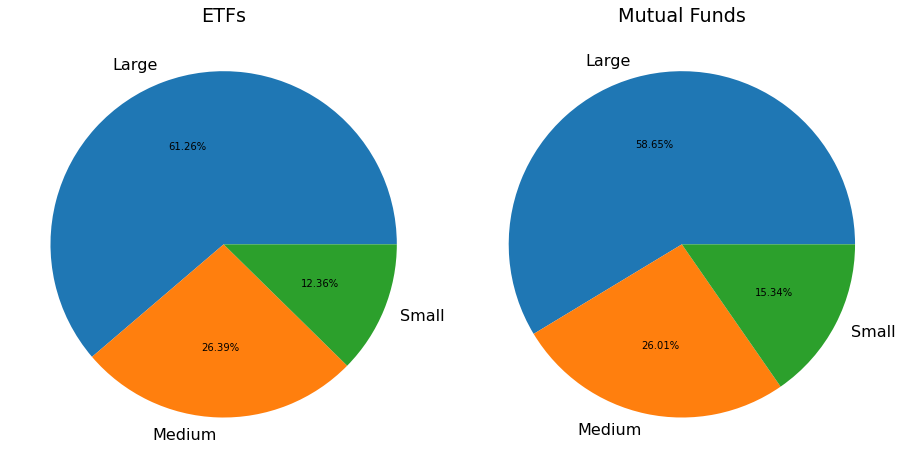

In [25]:
comparison_pies(df_etf,df_mf,'size_type','ETFs','Mutual Funds')

From the pie charts we can see the size of funds is pretty similar across Mutual Funds and ETFs. There are a slightly higher proportion of large Mutual Funds than large ETFs and there are slightly more medium sized ETFs than medium sized Mutual Funds. 

### Investment Type

There are three main investment types of for a fund: Growth, Value and Blend. The growth type is a fund that invests primarily in stocks that are expected to increase in capital value rather than yield high income. Value funds follow a policy that focuses on investing in stocks based on fundamental characteristics that are undervalued in quality. Blend funds hold a mix of both growth stock and value stock and contain only stocks and no fixed-income securities.

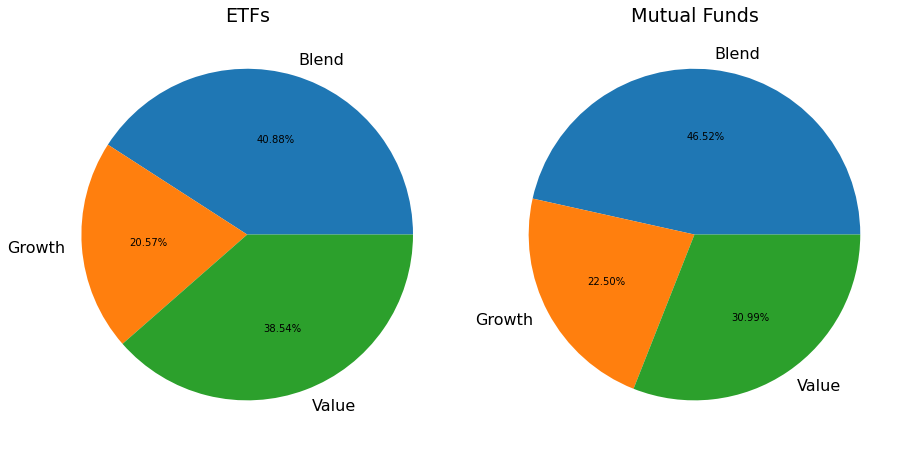

In [26]:
comparison_pies(df_etf,df_mf,'investment_type','ETFs','Mutual Funds')

The percentage of growth funds is very similar across Mutual Funds and ETFs, while the other two percentages are notably different. The percentage of blend funds in Mutual Funds is greater than the percentage in ETFs, while the percentage of growth funds in Mutual Funds is less than the percentage in ETFs. ETFs are more evenly distributed between blend and growth funds, while Mutual funds have a clear higher precentage of blend funds than growth. 

### Asset Distributions

These graphs shows us the percentages of each type of asset that make up the fund. A distribution is a payment of interest, principal, or dividend by the issuer of the security to investors, and in these graphs, the different distributions are stocks, bonds, cash, and other. 

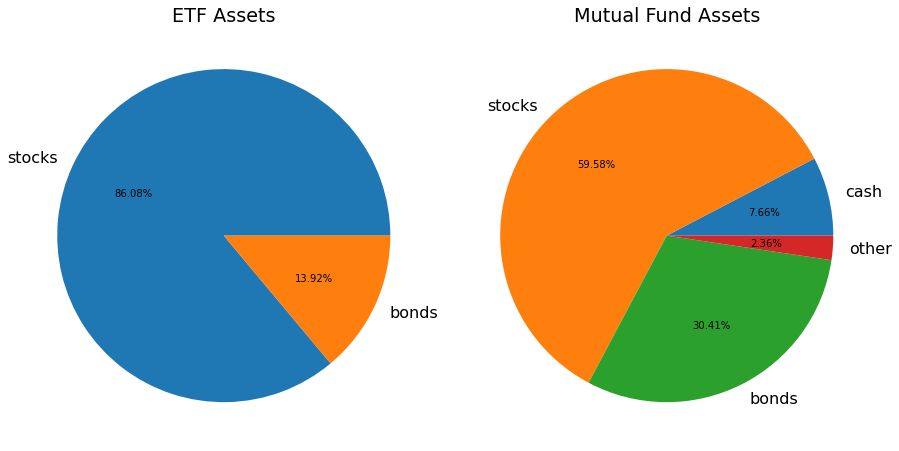

In [27]:
cols=[i for i in df_etf_asset.columns[1:3]]
cols2=[i for i in df_mf_asset.columns[1:7]]

multiple_percent_comp_bar(df_etf_asset,df_mf_asset,cols,cols2,'asset_','ETF Assets',"Mutual Fund Assets")

The asset distributions between Mutual Funds and ETFs appear to be very different. In the case of ETFs, there are only two different types of distributions to begin with-- the graph doesn't even feature cash and other, which are two distributions of the Mutual Funds. Between both graphs, however, the clear majority is in the stocks distribution. Also, both graphs have the second most amount in the bonds category. 

### Sector Distributions

These graphs shows us the distribution of which sector the funds are investing in. The different sectors in the graph tell us which industry the assets are being invested in.

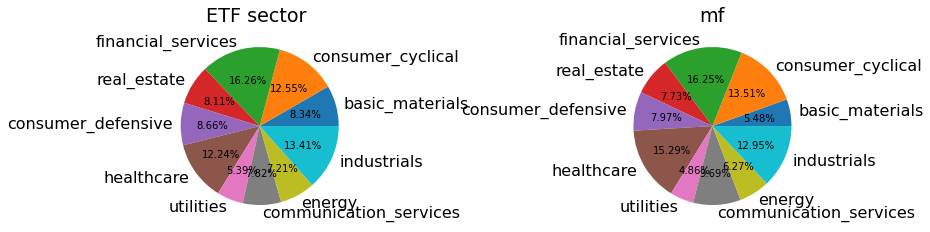

In [28]:
# Percentage invested in each sector in ETF 
cols=[i for i in df_mf_sector.columns[1:11]]
cols2=[i for i in df_etf_sector.columns[1:11]]

multiple_percent_comp_bar(df_etf_sector,df_mf_sector,cols,cols2,'sector_','ETF sector ','mf')

These two sector graphs are very similar between ETFs and Mutual Funds. Each sector has a very similar percentage, varying from around a 1% difference between Mutual Funds and ETFs. The sector with the largest difference is the basic materials sector, still with a minimal difference of approximately 3%. The majority for both graphs is financial services, and the minority for both graphs is utilities. 

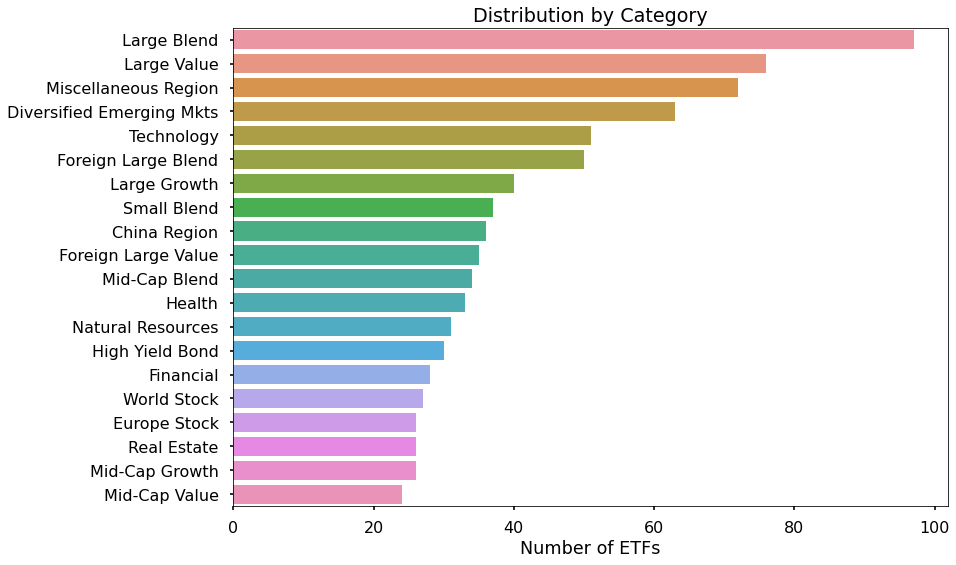

In [29]:
#ETF distribution by category 
plt.xlabel('Number of ETFs')
distribution_by_category(df_etf)

This graph shows us the distribution of the number of funds that make up each category. A fund category is a way of differentiating mutual funds according to their investment objectives and principal investment features. This categorization allows investors to spread their money around in a mix of funds with a variety of risk and return characteristics. The largest category of this dataset is the large blend, and the smallest is the mid-cap value. 


 Distribution of fund_alpha_3years according to size_type in ETFs:



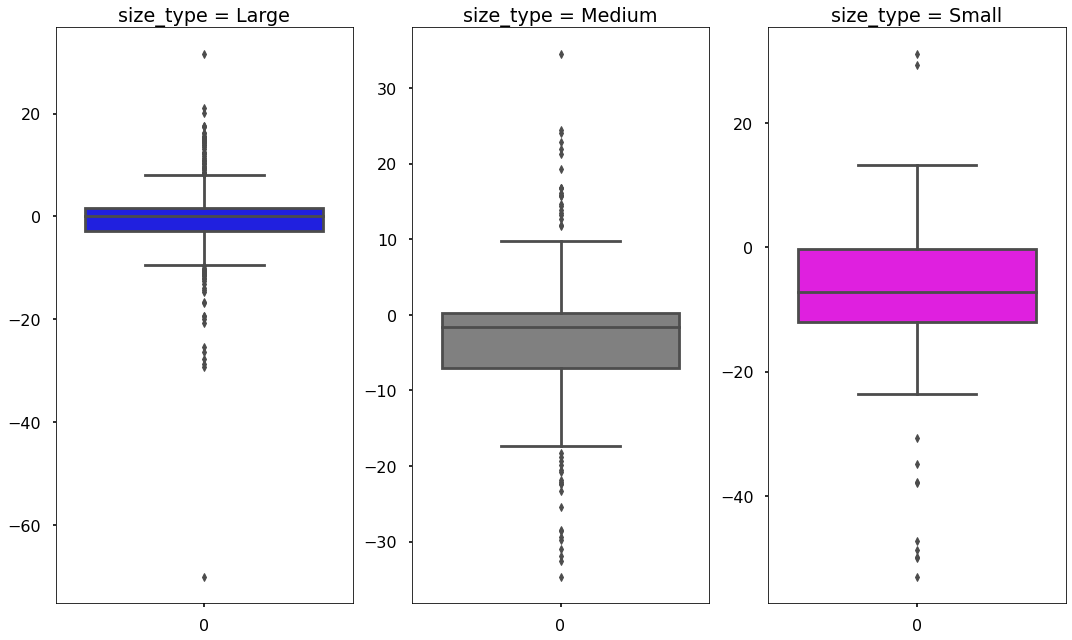

In [30]:
#ETF Fund size vs. alpha 3 years score
joined=pd.merge(df_etf,df_etf_stats)
dep_by_indep_boxplot(joined,'size_type','fund_alpha_3years','ETFs')

This graph shows the distribution of the alpha values of the funds with the corresponding size. The alpha value is often considered to represent the value that a portfolio manager adds or subtracts from a fund portfolio's return. We can see from these graphs that the large funds have a distribution that is clustered towards the top, meaning the alpha value is probably overall higher for the large funds. The medium funds have a more evenly distributed alpha value and so do the small funds. 


 Distribution of fund_return_ytd according to investment_type in ETFs:



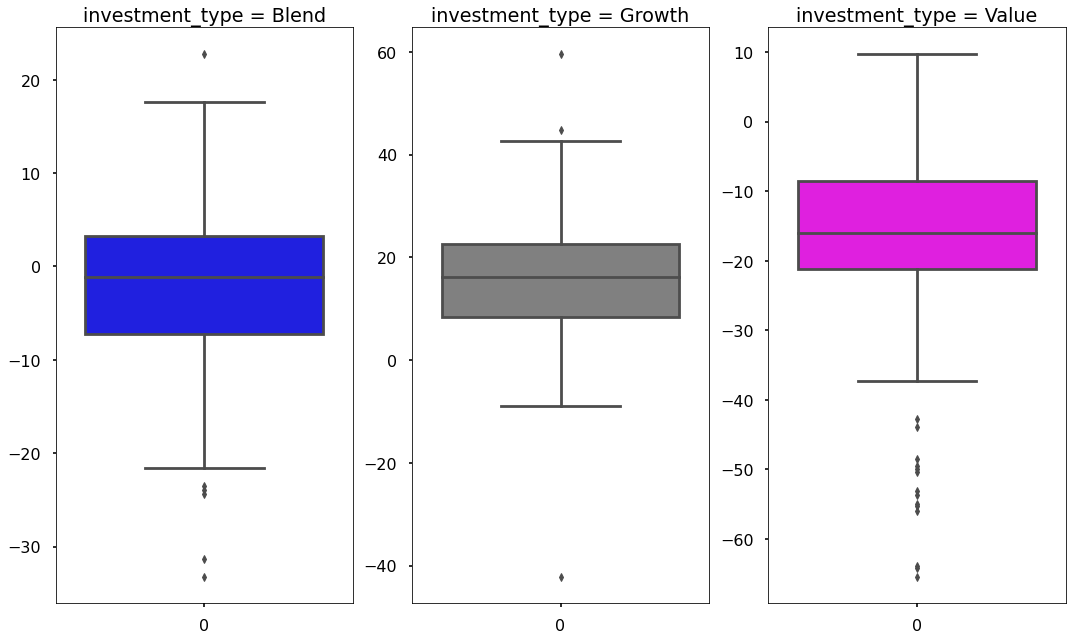

In [31]:
#Investment type vs. ETF YTD return
joined=pd.merge(df_etf,df_etf_return_history)
dep_by_indep_boxplot(joined,'investment_type','fund_return_ytd','ETFs')

This graph shows us the distribution of the fund returns (ytd) based on the investment type of a fund. The blend funds seem to have a very evenly distributed fund return (ytd), while the growth type seems to be a little more skewed towards the lower values of fund return, and the value type seems to be a little skewed towards the higher values of the fund return. 

## Summary Statistics for numeric ETF values

In [32]:
columns = []
means = []
standard_devs = []
medians = []
for cols in df_etf:
    if type(df_etf[cols][0]) == np.float64:
        columns.append(cols)
        means.append(df_etf[cols].mean())
        standard_devs.append(df_etf[cols].std())
        medians.append(df_etf[cols].median())


df_etf_summary_stats = pd.DataFrame()
df_etf_summary_stats['ETF Feature'] = columns
df_etf_summary_stats['Mean'] = means 
df_etf_summary_stats['Standard Deviation'] = standard_devs 
df_etf_summary_stats['Median'] = medians 

df_etf_summary_stats

,ETF Feature,Mean,Standard Deviation,Median
0,fund_yield,2.453672,2.247477,2.03
1,fund_return_ytd,-3.603826,17.378241,-2.44


## ETF ANALYSIS

In [33]:
#Creates two new dataframes where only the highest correlated variables are stored
df_etf_highest_corrs=pd.DataFrame(index=['Correlation'])

#Removes NaNs from fund return column
df_etf.dropna(subset=['fund_return_ytd'],inplace=True)

# __MUTUAL FUND SECTION__

## Exploratory analysis on Mutual Funds

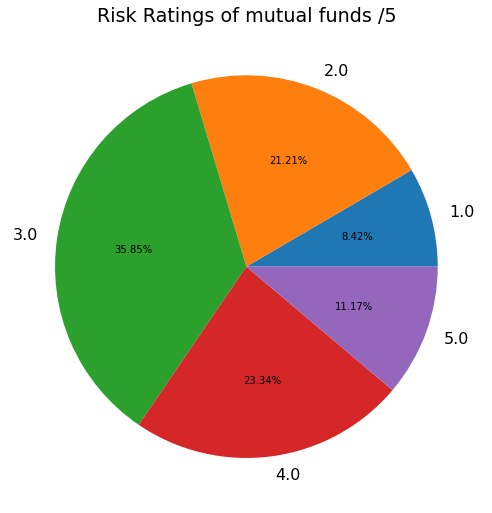

In [34]:
plt.title('Risk Ratings of mutual funds /5')
pie_chart(df_mf,'risk_rating')

This graph shows the breakdown of the risk ratings of the Mutual Funds in the data set. A risk rating is assessing the risks involved in the daily activities of a business, and in this case, assessing it on a scale from one to five. The risk ratings depends on the likelihood of the risk event occurring and the severity of the impact on the business and its employees. The most prominent risk rating in our Mutual Fund dataset is 3.0, making up 35.84% of the dataset, and the least prominent is 1.0 making up 8.41% of the dataset. 

This graph shows us the percentages of each type of asset that make up the fund. A distribution is a payment of interest, principal, or dividend by the issuer of the security to investors, and in this graph, the different distributions are stocks, bonds, cash, and other. The majority of the Mutual Fund dataset--59.58%-- is made up of the stock distribution, while the minority asset distribution is the other section, making up 2.36% is the bonds distribution. A not much greater minority is the 7.66% being the cash sector.  

This graph shows us the distribution of which sector the funds are investing in. The different sectors in the graph tell us which industry the assets are being invested in. In this case, 16.25% of this dataset is being invested in the financial services industry-- which is the largest amount of the graph. On the other hand, the smallest amount of the graph is the utilities sector of the graph that tells us that 4.86% of the dataset is investing in the utilities industry. 

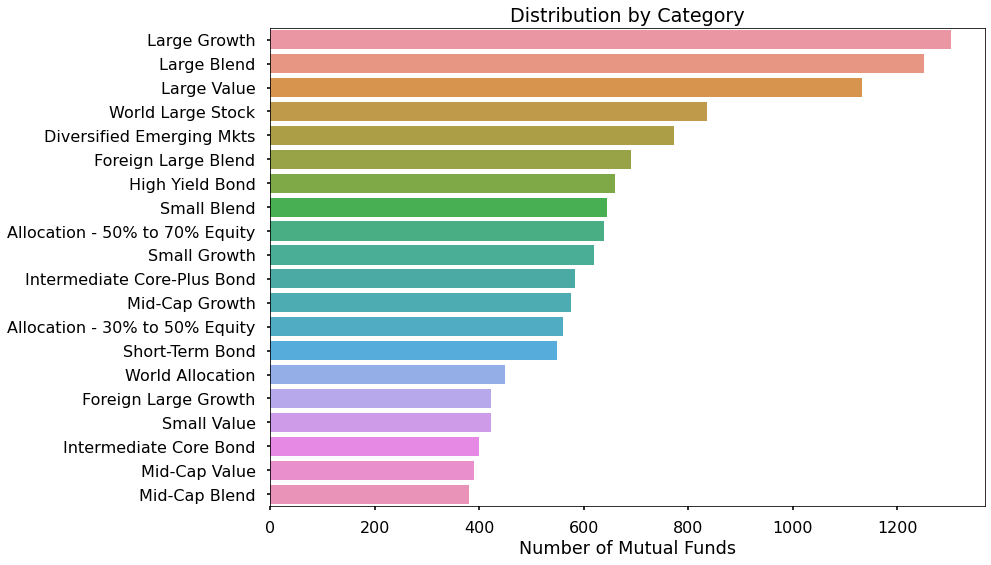

In [35]:
#Mutual funds distribution by category 
plt.xlabel('Number of Mutual Funds')
distribution_by_category(df_mf)

This graph shows us the distribution of the number of funds that make up each category. A fund category is a way of differentiating ETF’s according to their investment objectives and principal investment features. This categorization allows investors to spread their money around in a mix of funds with a variety of risk and return characteristics. The largest category of this dataset is the large growth-- with large blend close behind-- and the smallest is the mid-cap blend. 



 Distribution of price_earnings_ratio according to risk_rating in Mutual Funds:



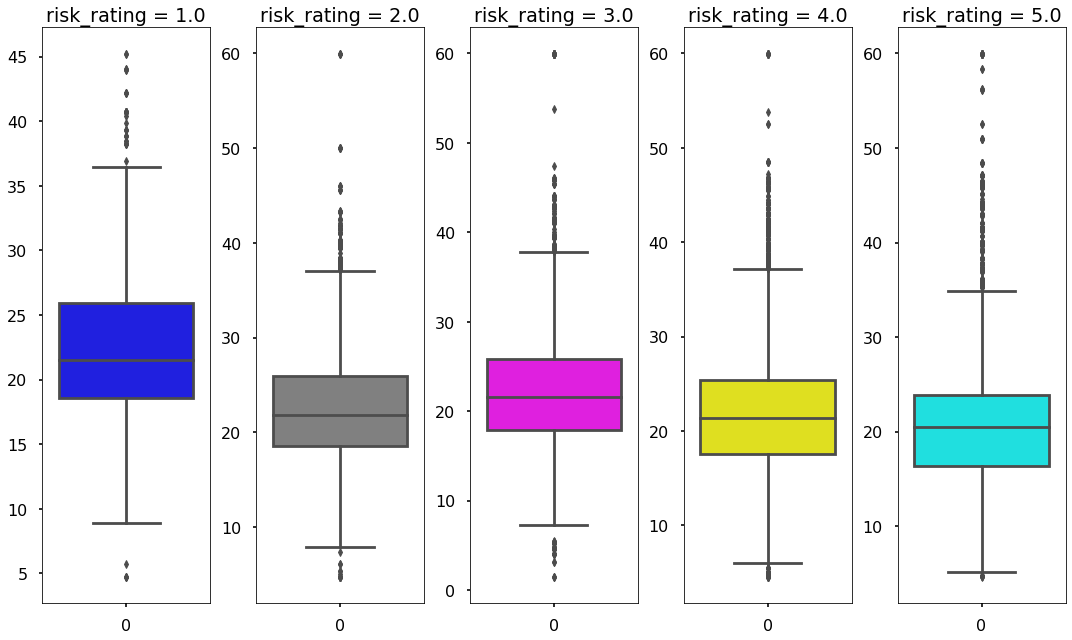

In [36]:
#Price earnings ratio vs. risk rating for Mutual Funds
joined=pd.merge(df_mf,df_mf_ratios)
dep_by_indep_boxplot(joined,'risk_rating','price_earnings_ratio','Mutual Funds')

This graph shows a box and wisker plot for each price book ratio values for each group of risk ratings. The price-to-book ratio, or P/B ratio, is a financial ratio used to compare a company's current market value to its book value. This graph plots the price book ratio values for the distributions of each risk rating. Based on this graph, as the risk rating goes up, it seems like that the distribution of the price book ratio goes down, forming somewhat of a downward trend with the boxes.  


 Distribution of fund_alpha_3years according to size_type in Mutual Fund:



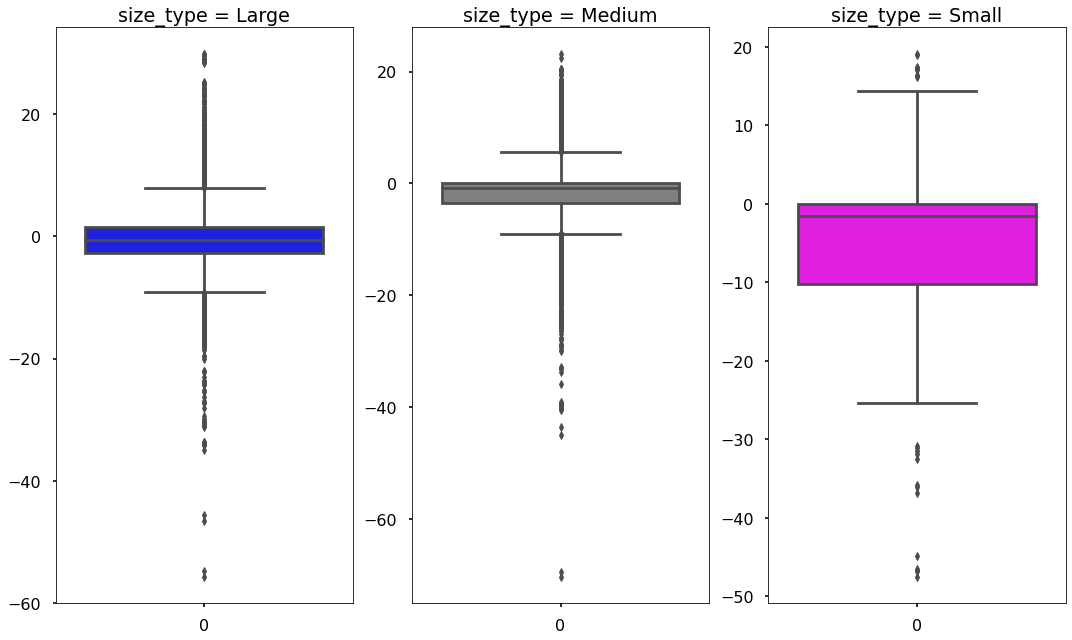

In [37]:
#Mutual Fund size vs. alpha 3 years value
joined=pd.merge(df_mf,df_mf_stats)
dep_by_indep_boxplot(joined,'size_type','fund_alpha_3years','Mutual Fund')

This graph shows the distribution of the alpha values of the funds with the corresponding size. The alpha value is often considered to represent the value that a portfolio manager adds or subtracts from a fund portfolio's return. We can see from these graphs that the medium funds have a distribution that is clustered towards the top, meaning the alpha value is probably overall higher for the large funds. The large and small sizes also seem to be clustered towards the top, just not as high as the medium.


 Distribution of fund_return_ytd according to investment_type in Mutual Fund:



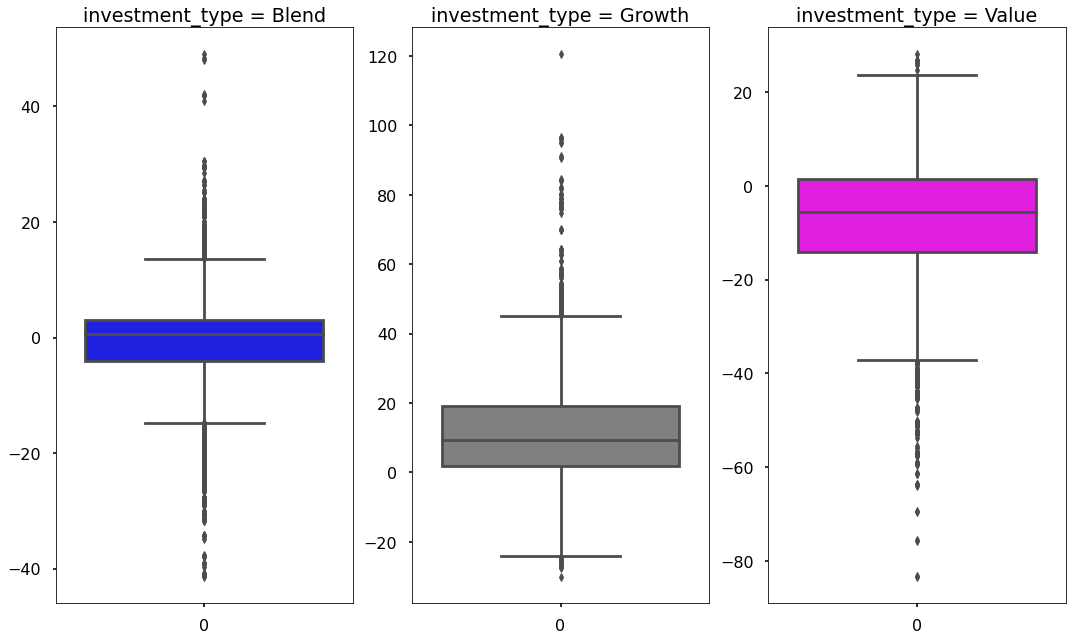

In [38]:
#Investment type vs. mutual fund YTD return
joined=pd.merge(df_mf,df_mf_return_history)
dep_by_indep_boxplot(joined,'investment_type','fund_return_ytd','Mutual Fund')

This graph shows us the distribution of the fund returns (ytd) based on the investment type of a fund. The blend funds seem to have a very evenly distributed fund return (ytd), while the growth type seems to be a little more skewed towards the lower values of fund return, and the value type seems to be a little skewed towards the higher values of the fund return-- very similar to the ETF graph. 

## Summary Statistics for numeric Mutual Fund values

In [39]:
columns = []
means = []
standard_devs = []
medians = []
for cols in df_mf:
    if type(df_mf[cols][0]) == np.float64:
        columns.append(cols)
        means.append(df_mf[cols].mean())
        standard_devs.append(df_mf[cols].std())
        medians.append(df_mf[cols].median())

df_mf_summary_stats = pd.DataFrame()
df_mf_summary_stats['MF Feature'] = columns
df_mf_summary_stats['Mean'] = means 
df_mf_summary_stats['Standard Deviation'] = standard_devs 
df_mf_summary_stats['Median'] = medians 

df_mf_summary_stats

,MF Feature,Mean,Standard Deviation,Median
0,rating,3.032126,1.102552,3.00
1,return_rating,3.024296,1.101567,3.00
2,risk_rating,3.076363,1.106091,3.00
3,median_market_cap,39238.487202,51251.055463,20772.24
4,bond_maturity,5.570877,2.546605,6.07
5,bond_duration,3.716140,1.663970,3.45
6,fund_yield,1.908593,3.230563,1.62
7,fund_return_ytd,-0.168995,12.525788,0.77


# __Pre-registration of Analyses:__

1. Highest Corrs
2. Predictive Variable (Casey) (chi-square test, log reg)
3. Time Frame (David)
4. Time Frame(Cam) (log reg2)
5. Sector (Cam) (log reg 3)

# __Coefficient of Correlation__

In [40]:
#Creates two new dataframes where only the highest correlated variables are stored
df_mf_highest_corrs=pd.DataFrame(index=['correlation'])
df_etf_highest_corrs=pd.DataFrame(index=['correlation'])

In [41]:
mf_joined=pd.merge(df_mf,df_mf_ratios).merge(df_mf_stats)
etf_joined=pd.merge(df_etf,df_etf_ratios).merge(df_etf_stats)
predictors=['fund_yield',
            'fund_net_annual_expense_ratio',
            'price_earnings_ratio',
            'price_book_ratio',
            'price_sales_ratio',
            'price_cashflow_ratio',
            'fund_sharpe_ratio_3years',
            'fund_sharpe_ratio_5years',
            'fund_sharpe_ratio_10years',
            'fund_alpha_3years',
            'fund_alpha_5years',
            'fund_alpha_10years',
            'fund_treynor_ratio_3years',
            'fund_treynor_ratio_5years',
            'fund_treynor_ratio_10years',
           ]

mf_corrz=bootstrap_correlations(mf_joined,predictors,'fund_return_ytd',50,30)
etf_corrz=bootstrap_correlations(etf_joined,predictors,'fund_return_ytd',50,30)


filter_correlations(mf_corrz,df_mf_highest_corrs)
filter_correlations(etf_corrz,df_etf_highest_corrs)

'''
corr_visualize(mf_vars,.4,'Correlation with fund_return_ytd - MFs',10)
plt.show()
print('\n')
corr_visualize(etf_vars,.2,'Correlation with fund_return_ytd - ETFs',10)
'''

df_mf_highest_corrs.head(30)

,fund_yield,price_earnings_ratio,price_book_ratio,price_sales_ratio,price_cashflow_ratio,fund_sharpe_ratio_3years,fund_sharpe_ratio_5years,fund_sharpe_ratio_10years,fund_alpha_3years,fund_alpha_5years,fund_alpha_10years,fund_treynor_ratio_3years,fund_treynor_ratio_5years,fund_treynor_ratio_10years
correlation,0.175634,0.520106,0.578,0.393556,0.55465,0.729426,0.625058,0.350014,0.675236,0.610866,0.364782,0.727474,0.615586,0.314126


In [42]:
df_etf_highest_corrs.head(30)

,fund_yield,price_earnings_ratio,price_book_ratio,price_sales_ratio,price_cashflow_ratio,fund_sharpe_ratio_3years,fund_sharpe_ratio_5years,fund_sharpe_ratio_10years,fund_alpha_3years,fund_alpha_5years,fund_alpha_10years,fund_treynor_ratio_3years,fund_treynor_ratio_5years,fund_treynor_ratio_10years
correlation,0.471822,0.47103,0.55682,0.310162,0.518078,0.71906,0.64018,0.362328,0.6934,0.552524,0.42658,0.73327,0.601692,0.311622


In [43]:
print('ques')

ques


In [44]:
#Sorting by decreasing value so first 5 entries are the 5 highest correlated variables
df_mf_highest_corrs=df_mf_highest_corrs.T.sort_values(by=['correlation'],ascending=False)
df_etf_highest_corrs=df_etf_highest_corrs.T.sort_values(by=['correlation'],ascending=False)

etf_vars=df_etf_highest_corrs.index[:5]
mf_vars=df_mf_highest_corrs.index[:5]

#First instance of df_mf3/df_etf3
df_mf3[mf_vars]=StandardScaler().fit_transform(df_mf3[mf_vars])
df_etf3[etf_vars]=StandardScaler().fit_transform(df_etf3[etf_vars])

df_mf3['fund_return_ytd']=StandardScaler().fit_transform(df_mf3[['fund_return_ytd']])
df_etf3['fund_return_ytd']=StandardScaler().fit_transform(df_etf3[['fund_return_ytd']])

df_mf3['category_return_ytd']=StandardScaler().fit_transform(df_mf3[['category_return_ytd']])
df_etf3['category_return_ytd']=StandardScaler().fit_transform(df_etf3[['category_return_ytd']])

df_mf3['score']=0
df_etf3['score']=0

for var in mf_vars:   
    mf_score=df_mf3[var]*(df_mf_highest_corrs.loc[var,'correlation'])
    df_mf3['score']+=mf_score
    #print(mf_score)


for var in etf_vars:   
    etf_score=df_etf3[var]*(df_etf_highest_corrs.loc[var,'correlation'])
    df_etf3['score']+=etf_score
    #print(etf_score)

mf_cols=df_mf.columns.to_list()
mf_cols.extend(mf_vars)
mf_cols.append('score')
mf_cols.append('category_return_ytd')
mf_final=pd.DataFrame()
for col in mf_cols:
    mf_final[col]=df_mf3[col]

etf_cols=df_etf.columns.to_list()
etf_cols.extend(etf_vars)
etf_cols.append('score')
etf_cols.append('category_return_ytd')
etf_final=pd.DataFrame()
for col in etf_cols:
    etf_final[col]=df_etf3[col]

In [45]:
df_mf_highest_corrs.head(10)

,correlation
fund_sharpe_ratio_3years,0.729426
fund_treynor_ratio_3years,0.727474
fund_alpha_3years,0.675236
fund_sharpe_ratio_5years,0.625058
fund_treynor_ratio_5years,0.615586
fund_alpha_5years,0.610866
price_book_ratio,0.578000
price_cashflow_ratio,0.554650
price_earnings_ratio,0.520106
price_sales_ratio,0.393556


In [46]:
#Adding column to MF dataframe that tells whether it is above average return
ytd_index=mf_final.columns.get_loc('fund_return_ytd')
cat_ytd_index=mf_final.columns.get_loc('category_return_ytd')

greater_list=[]
for i in range(mf_final.shape[0]):
    if (mf_final.iloc[i,ytd_index]< mf_final.iloc[i,cat_ytd_index]):
        greater_list.append(0)
    else:
        greater_list.append(1)

mf_final['>average']=greater_list
mf_final['>average'].head(10)


0    0
1    0
2    1
3    1
4    0
5    0
6    0
7    1
8    0
9    0
Name: >average, dtype: int64

In [47]:
#Adding column to ETF dataframe that tells whether it is above average return
ytd_index=etf_final.columns.get_loc('fund_return_ytd')
cat_ytd_index=etf_final.columns.get_loc('category_return_ytd')

greater_list=[]
for i in range(etf_final.shape[0]):
    if (etf_final.iloc[i,ytd_index]< etf_final.iloc[i,cat_ytd_index]):
        greater_list.append(0)
    else:
        greater_list.append(1)

etf_final['>average']=greater_list
etf_final['>average'].head(0)


Series([], Name: >average, dtype: int64)

Predictors: score
The log reg model predicts whether fund return is above average with an accuracy of 0.556
The R-squared value is 0.566


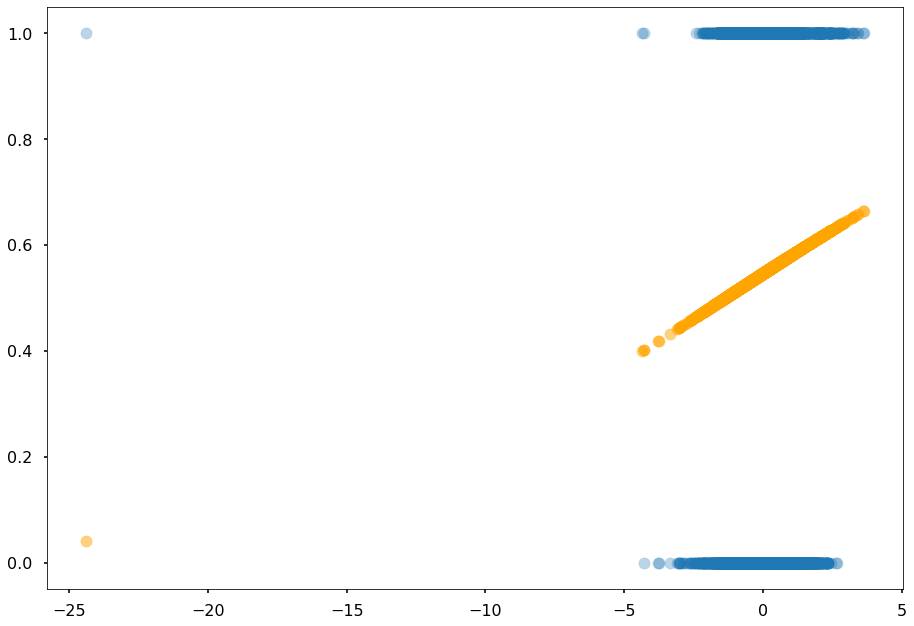



Predictors: score
The log reg model predicts whether fund return is above average with an accuracy of 0.725
The R-squared value is 0.706


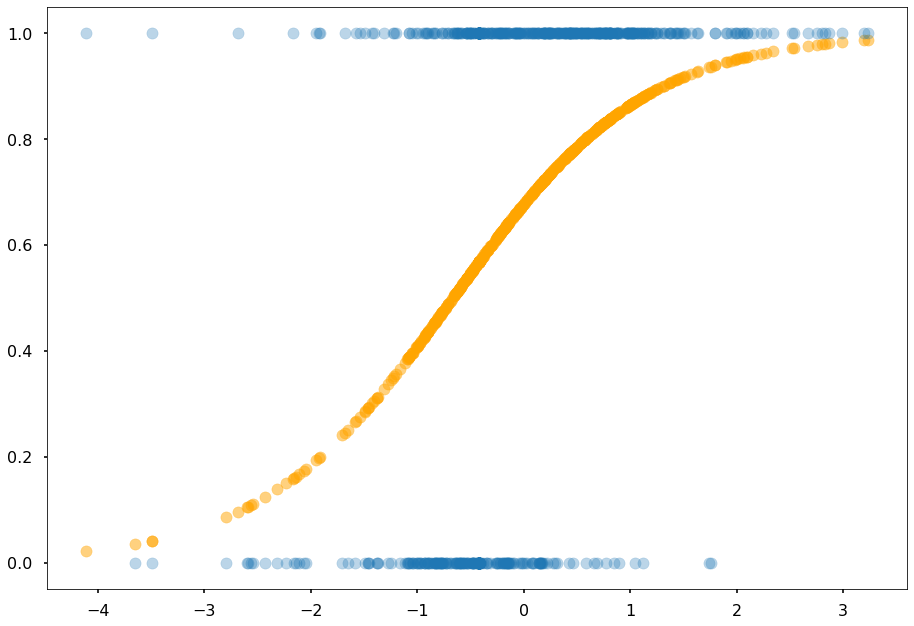

In [48]:
mf_final.dropna(inplace=True)
log_prob(mf_final,'score')
plt.show()
print('\n')
log_prob(etf_final,'score')

# __Analysis of predictive accuracy of variables over time__

In [49]:
#First instance of df_mf3,df_etf3
mf_short= cleanbykeyword(df_mf3,'3years').dropna()
mf_med= cleanbykeyword(df_mf3,'5years').dropna()
mf_long= cleanbykeyword(df_mf3,'10years').dropna()

etf_short= cleanbykeyword(df_etf2,'3years').dropna()
etf_med= cleanbykeyword(df_etf2,'5years').dropna()
etf_long= cleanbykeyword(df_etf2,'10years').dropna()


mf_long.columns

Index(['fund_symbol', 'fund_return_10years', 'fund_alpha_10years',
       'fund_beta_10years', 'fund_mean_annual_return_10years',
       'fund_r_squared_10years', 'fund_standard_deviation_10years',
       'fund_sharpe_ratio_10years', 'fund_treynor_ratio_10years'],
      dtype='object')

In [50]:
#short term
predictors=mf_short.columns.to_list()[2:]
print('Predictors: {}'.format(predictors))
mf_short_corrs=bootstrap_correlations(mf_short,predictors,'fund_return_3years',60,50)
#corr_visualize(mf_short_corrs,.1,'MFs short term',12)
plt.show()
print('\n')

predictors=etf_short.columns.to_list()[2:]
etf_short_corrs=bootstrap_correlations(etf_short,predictors,'fund_return_3years',60,50)
#corr_visualize(etf_short_corrs,.2,'ETFs short term',10)
plt.tight_layout()

Predictors: ['fund_alpha_3years', 'fund_beta_3years', 'fund_mean_annual_return_3years', 'fund_r_squared_3years', 'fund_standard_deviation_3years', 'fund_sharpe_ratio_3years', 'fund_treynor_ratio_3years']




<Figure size 921.6x633.6 with 0 Axes>

In [51]:
#med term
predictors=mf_med.columns.to_list()[2:]
print('Predictors: {}'.format(predictors))
mf_med_corrs=bootstrap_correlations(mf_med,predictors,'fund_return_5years',60,50)
#corr_visualize(mf_med_corrs,.2,'MFs med term',12)
plt.show()
print('\n')

predictors=etf_med.columns.to_list()[2:]
etf_med_corrs=bootstrap_correlations(etf_med,predictors,'fund_return_5years',60,50)
#corr_visualize(etf_med_corrs,.2,'ETFs med term',10)
plt.tight_layout()

Predictors: ['fund_alpha_5years', 'fund_beta_5years', 'fund_mean_annual_return_5years', 'fund_r_squared_5years', 'fund_standard_deviation_5years', 'fund_sharpe_ratio_5years', 'fund_treynor_ratio_5years']




<Figure size 921.6x633.6 with 0 Axes>

In [52]:
#long term
predictors=mf_long.columns.to_list()[2:]
print('Predictors: {}'.format(predictors))
mf_long_corrs=bootstrap_correlations(mf_long,predictors,'fund_return_10years',60,50)
#corr_visualize(mf_long_corrs,.1,'MFs long term',10)
plt.show()
print('\n')

predictors=etf_long.columns.to_list()[2:]
etf_long_corrs=bootstrap_correlations(etf_long,predictors,'fund_return_10years',60,50)
#corr_visualize(etf_long_corrs,.2,'ETFs long term',10)

Predictors: ['fund_alpha_10years', 'fund_beta_10years', 'fund_mean_annual_return_10years', 'fund_r_squared_10years', 'fund_standard_deviation_10years', 'fund_sharpe_ratio_10years', 'fund_treynor_ratio_10years']




In [53]:
#Consolidating short, medium, long term dataframes into one encompassing dataframe 
mf_short_corrs=mf_short_corrs.T.rename({'fund_alpha_3years':'fund_alpha','fund_beta_3years':'fund_beta','fund_mean_annual_return_3years':'fund_mean_annual_return','fund_r_squared_3years':'fund_r_squared','fund_standard_deviation_3years':'fund_standard_deviation','fund_sharpe_ratio_3years':'fund_sharpe_ratio','fund_treynor_ratio_3years':'fund_treynor_ratio',},axis='columns').T
etf_short_corrs=etf_short_corrs.T.rename({'fund_alpha_3years':'fund_alpha','fund_beta_3years':'fund_beta','fund_mean_annual_return_3years':'fund_mean_annual_return','fund_r_squared_3years':'fund_r_squared','fund_standard_deviation_3years':'fund_standard_deviation','fund_sharpe_ratio_3years':'fund_sharpe_ratio','fund_treynor_ratio_3years':'fund_treynor_ratio'},axis='columns').T

mf_med_corrs=mf_med_corrs.T.rename({'fund_alpha_5years':'fund_alpha','fund_beta_5years':'fund_beta','fund_mean_annual_return_5years':'fund_mean_annual_return','fund_r_squared_5years':'fund_r_squared','fund_standard_deviation_5years':'fund_standard_deviation','fund_sharpe_ratio_5years':'fund_sharpe_ratio','fund_treynor_ratio_5years':'fund_treynor_ratio'},axis='columns').T
etf_med_corrs=etf_med_corrs.T.rename({'fund_alpha_5years':'fund_alpha','fund_beta_5years':'fund_beta','fund_mean_annual_return_5years':'fund_mean_annual_return','fund_r_squared_5years':'fund_r_squared','fund_standard_deviation_5years':'fund_standard_deviation','fund_sharpe_ratio_5years':'fund_sharpe_ratio','fund_treynor_ratio_5years':'fund_treynor_ratio'},axis='columns').T

mf_long_corrs=mf_long_corrs.T.rename({'fund_alpha_10years':'fund_alpha','fund_beta_10years':'fund_beta','fund_mean_annual_return_10years':'fund_mean_annual_return','fund_r_squared_10years':'fund_r_squared','fund_standard_deviation_10years':'fund_standard_deviation','fund_sharpe_ratio_10years':'fund_sharpe_ratio','fund_treynor_ratio_10years':'fund_treynor_ratio'},axis='columns').T
etf_long_corrs=etf_long_corrs.T.rename({'fund_alpha_10years':'fund_alpha','fund_beta_10years':'fund_beta','fund_mean_annual_return_10years':'fund_mean_annual_return','fund_r_squared_10years':'fund_r_squared','fund_standard_deviation_10years':'fund_standard_deviation','fund_sharpe_ratio_10years':'fund_sharpe_ratio','fund_treynor_ratio_10years':'fund_treynor_ratio' },axis='columns').T

mf_short_corrs['term']='short'
etf_short_corrs['term']='short'

mf_med_corrs['term']='med'
etf_med_corrs['term']='med'

mf_long_corrs['term']='long'
etf_long_corrs['term']='long'

etf_corrs=pd.concat([etf_short_corrs,etf_med_corrs,etf_long_corrs])
mf_corrs=pd.concat([mf_short_corrs,mf_med_corrs,mf_long_corrs])

etf_corrs.head(0)

,correlation,term


**Visualizing Variable Correlations Across Different Time Frames**

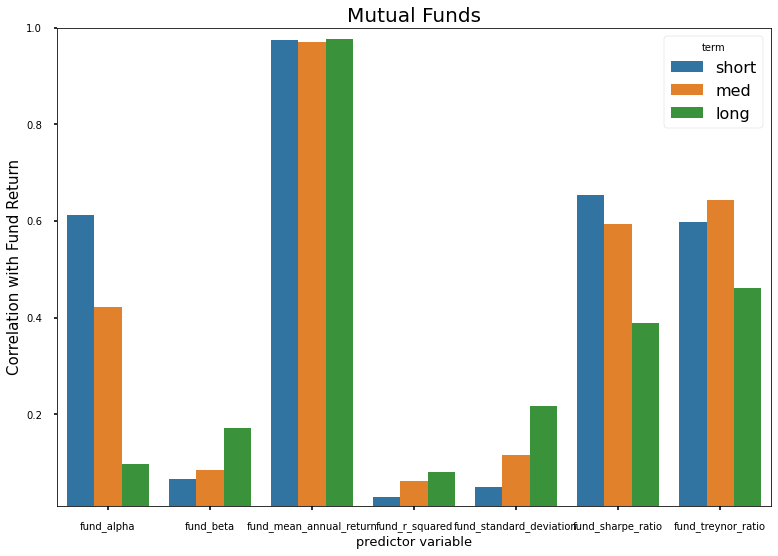

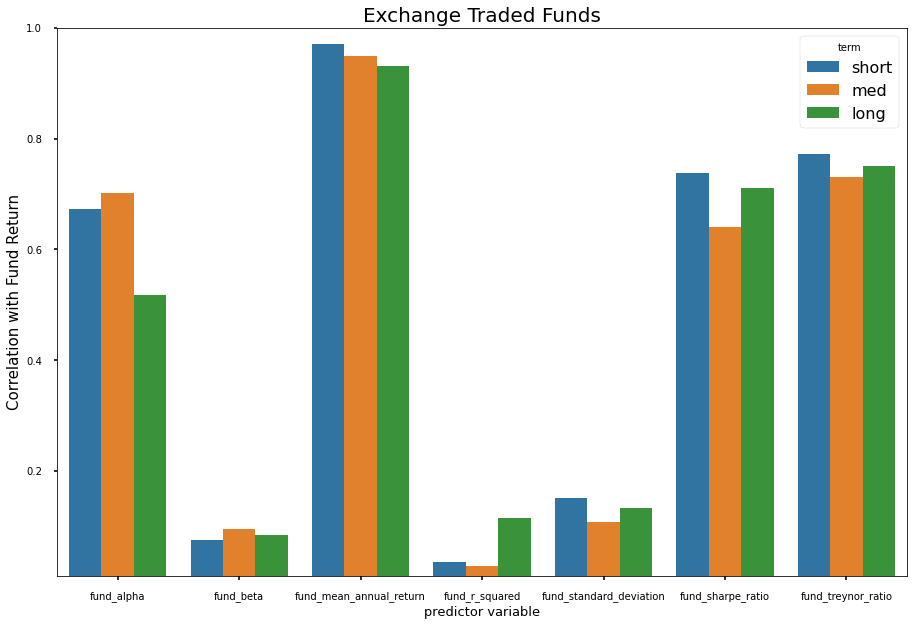

In [54]:
mf_clean=mf_corrs[mf_corrs['correlation']>.01]
mf_plot=sns.barplot(x=mf_clean.index,y=mf_clean['correlation'],data=mf_clean,hue='term')
plt.tick_params(labelsize=10)
plt.title("Mutual Funds", fontsize = 20)
plt.xlabel("predictor variable", fontsize = 13)
plt.ylabel("Correlation with Fund Return", fontsize = 15)
mf_plot.set_ylim(.01, 1.0)
plt.show()

print('\n')
etf_clean=etf_corrs[etf_corrs['correlation']>.01]
etf_plot=sns.barplot(x=etf_clean.index,y=etf_clean['correlation'],data=etf_clean,hue='term')
plt.tick_params(labelsize=10)
plt.title("Exchange Traded Funds", fontsize = 20)
plt.xlabel("predictor variable", fontsize = 13)
plt.ylabel("Correlation with Fund Return", fontsize = 15)
etf_plot.set_ylim(.01, 1.0)
plt.tight_layout()
plt.show()

**Observations:**
1. We find that fund_mean_annual_return has a near perfect correlation with fund_return across all timeframes. 
2. The Sharpe and Treynor Ratios seem to be more correlated with ETFs than MFs.
3. We find that as we increase the time frame, the predictive accuracy of our model drops off for Mutal Funds, but not for ETFs. This can be seen by comparing the green column in the graph with the blue and orange columns, where you can clearly see a sharp decline in correlation as you increase time frame in MFs. This is most noticable for the alpha variable, which drops to single digits in long term MFs but remains at ~50% in long term ETFs.
**Conclusions**
1. To avoid 'cheating', we are going to exclude fund_mean_annual_return from future calculations and use other predictor variables.
2. **ETFs appear to much easier to predict in the long term than Mutual Funds. Thus, we conclude that ETFs are a superior long-term investment to Mutual Funds.**

## __Time Frame Analysis__

A common question amongst individuals investing in a fund is how long to hold that specific fund position. Based off the various financial circumstances of each investor, fund positions can be held for various lengths of time. In this section we look for the ideal length of time to hold fund positions for each of the fund types, and an answer to the general question if there is a superior fund type for investing for a known length of time.

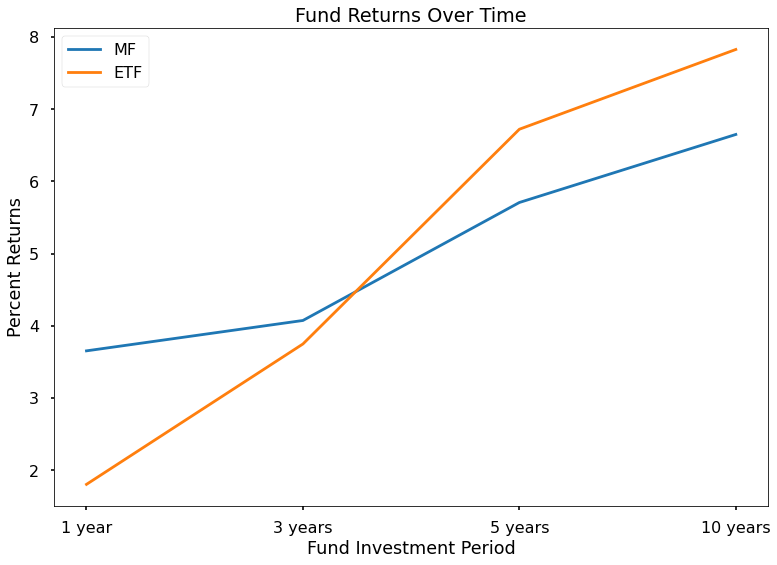

In [55]:
mfReturns=df_mf_return_history[['fund_return_1year','fund_return_3years','fund_return_5years','fund_return_10years']].mean()
etfReturns=df_etf_return_history[['fund_return_1year','fund_return_3years','fund_return_5years','fund_return_10years']].mean()


names=['1 year','3 years','5 years','10 years']
mfReturns.set_axis(names,axis=0,inplace=True)
etfReturns.set_axis(names,axis=0,inplace=True)


plt.plot(mfReturns)
plt.plot(etfReturns)

plt.title('Fund Returns Over Time')
plt.ylabel('Percent Returns')
plt.xlabel('Fund Investment Period')
plt.legend(['MF','ETF'])


As we can see from this graph, Mutual Funds initially have greater returns than ETFs for the first 3 years of holding the fund position. This is because the active management style of Mutual Funds allows the fund to be more agile and reactive in their decisions, leading to more profitable returns in the short term. After 5 years of holding the fund investment ETF returns start to eclipse the returns of Mutual Funds, and from the period of 5 to 10 years the returns of ETFs are greater than that of mutual funds.

There are several different 'kinds' of fund types. The main 3 types are growth funds, value funds, and blend funds. Growth funds are funds associate with a higher risk rating in order to potentially gain more rewards. Value funds are often cheaper than growth funds and pay a dividend to its shareholders. While Blend funds are a mix of the two.

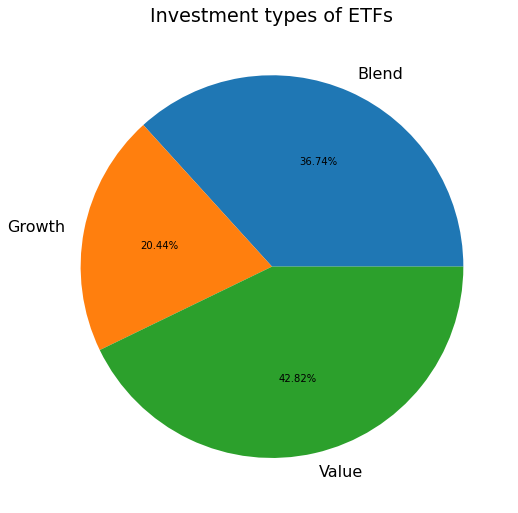

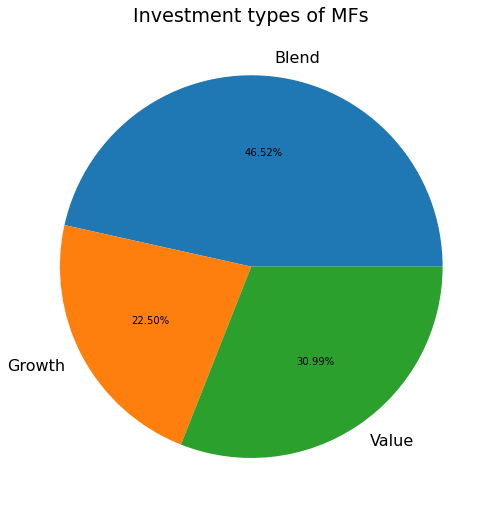

In [56]:
plt.title('Investment types of ETFs')
pie_chart(df_etf,'investment_type')
plt.title('Investment types of MFs')
pie_chart(df_mf,'investment_type')

How do the returns over time compare between these fund investing styles?

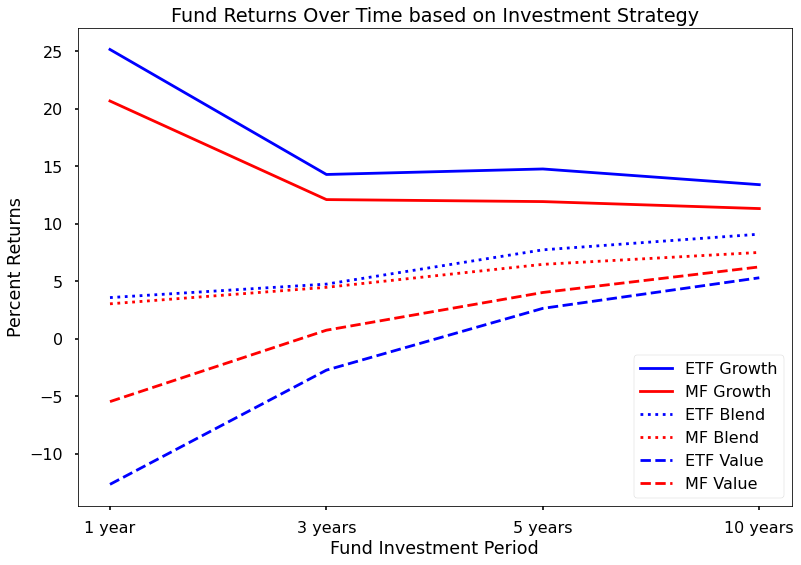

In [57]:
#sorting by investment type
mfGrowth=df_mf.where(df_mf['investment_type']=='Growth')
mfValue=df_mf.where(df_mf['investment_type']=='Value')
mfBlend=df_mf.where(df_mf['investment_type']=='Blend')

etfGrowth=df_etf.where(df_etf['investment_type']=='Growth')
etfValue=df_etf.where(df_etf['investment_type']=='Value')
etfBlend=df_etf.where(df_etf['investment_type']=='Blend')


#merging fund history
etfGrowth=pd.merge(etfGrowth,df_etf_return_history).dropna()
etfValue=pd.merge(etfValue,df_etf_return_history).dropna()
etfBlend=pd.merge(etfBlend,df_etf_return_history).dropna()

mfGrowth=pd.merge(mfGrowth,df_mf_return_history).dropna()
mfValue=pd.merge(mfValue,df_mf_return_history).dropna()
mfBlend=pd.merge(mfBlend,df_mf_return_history).dropna()




etfGrowthReturns=etfGrowth[['fund_return_1year','fund_return_3years','fund_return_5years','fund_return_10years']].mean()
etfValueReturns=etfValue[['fund_return_1year','fund_return_3years','fund_return_5years','fund_return_10years']].mean()
etfBlendReturns=etfBlend[['fund_return_1year','fund_return_3years','fund_return_5years','fund_return_10years']].mean()

mfGrowthReturns=mfGrowth[['fund_return_1year','fund_return_3years','fund_return_5years','fund_return_10years']].mean()
mfValueReturns=mfValue[['fund_return_1year','fund_return_3years','fund_return_5years','fund_return_10years']].mean()
mfBlendReturns=mfBlend[['fund_return_1year','fund_return_3years','fund_return_5years','fund_return_10years']].mean()


names=['1 year','3 years','5 years','10 years']

etfGrowthReturns.set_axis(names,axis=0,inplace=True)
etfValueReturns.set_axis(names,axis=0,inplace=True)
etfBlendReturns.set_axis(names,axis=0,inplace=True)

mfGrowthReturns.set_axis(names,axis=0,inplace=True)
mfValueReturns.set_axis(names,axis=0,inplace=True)
mfBlendReturns.set_axis(names,axis=0,inplace=True)



plt.plot(etfGrowthReturns,color = 'blue')
plt.plot(mfGrowthReturns,color = 'red')


plt.plot(etfBlendReturns,color = 'blue',ls='dotted')
plt.plot(mfBlendReturns,color = 'red',ls='dotted')

plt.plot(etfValueReturns,color = 'blue',ls='dashed')
plt.plot(mfValueReturns,color = 'red',ls='dashed')




plt.title('Fund Returns Over Time based on Investment Strategy')
plt.ylabel('Percent Returns')
plt.xlabel('Fund Investment Period')
plt.legend(['ETF Growth','MF Growth','ETF Blend','MF Blend','ETF Value','MF Value'])



This graph shows the surpising differences in fund returns based on Investment strategy. Funds with growth strategies have overwhelming amounts of fund returns in the first year of investment and then their returns rapidly decline after 1 year. Within growth funds, ETF's have a significant advantage over Mutual Funds for all investment periods. ETFs have on average 10% better returns at 1 year and roughly 5% better returns after 1 year. For blend funds the returns start slightly above zero and steadily increase all the way to 10 years. There is almost no difference between Mutual Funds and ETFs for blend funds. The blend funds exhibit a shape very similar to the returns over time for each respective fund shown previously, and this is because blend funds make up the majority percentage of fund strategies. Value funds start off with very large negative returns and rapidly increase after 1 year and cross into the positive return threshold at about 2 years for mutual funds and 4 years for ETFs. Value funds have negative returns because they pay their shareholders a higher dividend compared to blend funds, who pay a small dividend, and Growth funds who usually pay close to no dividends.

In order to get a more accurate representation of the Total fund returns we should consider the fund yield, which shows the interest and dividends the fund pays throughout the course of a single year.

In [58]:
#sorting by investment type
mfGrowth=df_mf.where(df_mf['investment_type']=='Growth')
mfValue=df_mf.where(df_mf['investment_type']=='Value')
mfBlend=df_mf.where(df_mf['investment_type']=='Blend')

etfGrowth=df_etf.where(df_etf['investment_type']=='Growth')
etfValue=df_etf.where(df_etf['investment_type']=='Value')
etfBlend=df_etf.where(df_etf['investment_type']=='Blend')


#merging fund history
etfGrowth=pd.merge(etfGrowth,df_etf).dropna()
etfValue=pd.merge(etfValue,df_etf).dropna()
etfBlend=pd.merge(etfBlend,df_etf).dropna()

mfGrowth=pd.merge(mfGrowth,df_mf).dropna()
mfValue=pd.merge(mfValue,df_mf).dropna()
mfBlend=pd.merge(mfBlend,df_mf).dropna()



#taking the average for each
etfGrowthYield=etfGrowth[['fund_yield']].mean()
etfBlendYield=etfBlend[['fund_yield']].mean()
etfValueYield=etfValue[['fund_yield']].mean()

mfGrowthYield=mfGrowth[['fund_yield']].mean()
mfBlendYield=mfBlend[['fund_yield']].mean()
mfValueYield=mfValue[['fund_yield']].mean()


#putting data into a dataframe
data = {'Fund type and Strategy': ['ETF Growth ','ETF Blend','ETF Value','MF Growth ','MF Blend','MF Value'],
        'Fund Yield': [.642024,1.80875,3.60017,.873461,1.723154 ,2.651961]
        }

df = pd.DataFrame(data, columns = ['Fund type and Strategy', 'Fund Yield'])

df

,Fund type and Strategy,Fund Yield
0,ETF Growth,0.642024
1,ETF Blend,1.808750
2,ETF Value,3.600170
3,MF Growth,0.873461
4,MF Blend,1.723154
5,MF Value,2.651961


Predictors: score
The log reg model predicts whether fund return is above average with an accuracy of 0.515
The R-squared value is 0.522


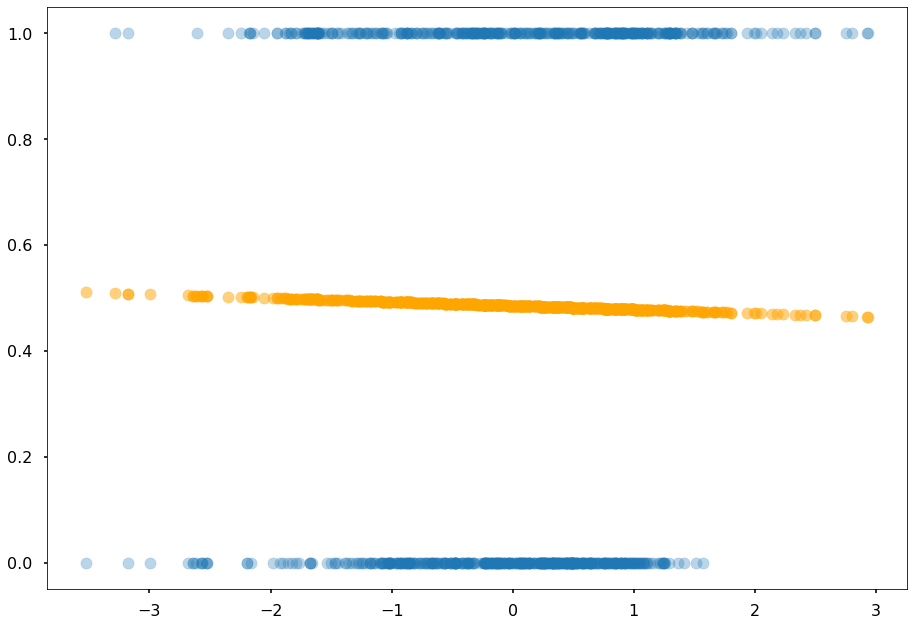



Predictors: score
The log reg model predicts whether fund return is above average with an accuracy of 0.963
The R-squared value is 0.856


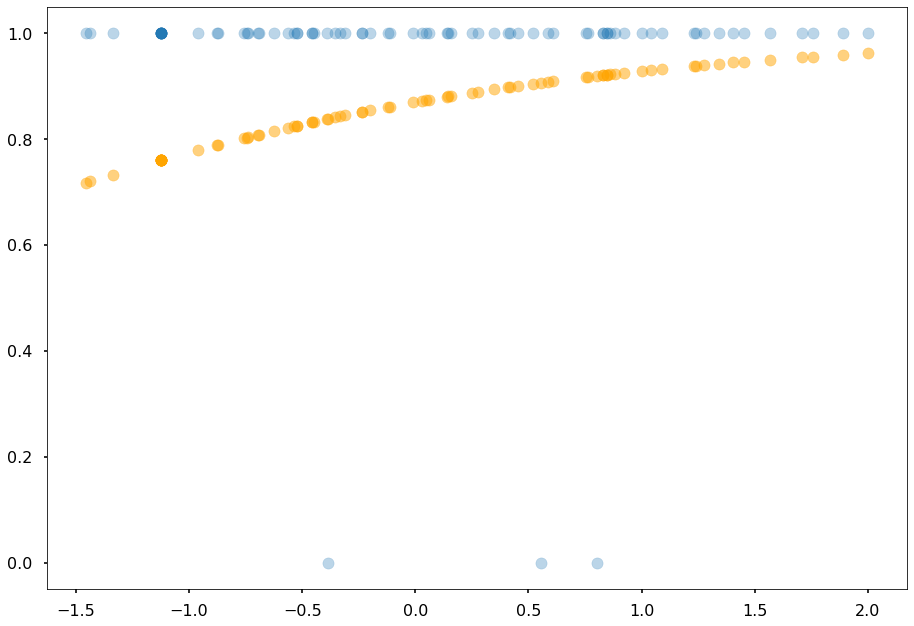

In [59]:
mf_growth=mf_final.loc[mf_final['investment_type']=='Growth'].dropna()
log_prob(mf_growth,'score')
plt.show()
print('\n')
etf_growth=etf_final.loc[etf_final['investment_type']=='Growth'].dropna()
log_prob(etf_growth,'score')

# __Analysis of sectors of investment:__

In [ ]:
# Percentage invested in each sector
cols=[i for i in df_mf_sector.columns[1:12]]
plt.title('Sector distribution in Mutual Funds')
percent_comp_bar(df_mf_sector,cols,'sector_')
print('\n')
plt.title('Sector distribution in ETFs')
percent_comp_bar(df_etf_sector,cols,'sector_')




As we can see from the bar charts, the average sector holdings between both Mutual Funds and Exchange Traded Funds are very similar. The biggest margin of difference in sector holdings is about 3%. The biggest differences between sector holdings are that ETF's seem to have a 3% greater investment in companies in the basic materials sector and Mutual funds have roughly a 3% greater involvement in technology,healthcare, and communication services. We will perform a regression to see how correlated percent investment in each financial sector is with fund returns and if this slight difference in sector investment has an impact on fund returns.

Doing a single regression on sector investment and fund returns:

In [ ]:
sectors=['sector_basic_materials','sector_consumer_cyclical','sector_financial_services','sector_real_estate',
        'sector_communication_services','sector_energy',
        'sector_industrials','sector_technology','sector_healthcare']

mfjoined=pd.merge(df_mf,df_mf_sector).dropna()
mfjoined=mfjoined.merge(df_mf_return_history).dropna()

mfs=get_correlations(mfjoined,sectors,'fund_return_ytd')


etfjoined=pd.merge(df_etf,df_etf_sector).dropna()
etfjoined=etfjoined.merge(df_etf_return_history).dropna()

etfs=get_correlations(etfjoined,sectors,'fund_return_ytd')

etfs.head()



Cleaning up the column names: 

In [ ]:

names=['Materials','Consumer Cyclical','Financial Services','Real Estate','Communication services','Energy','Industrials','Technology','Healthcare']
mfs.set_axis(names,axis=0,inplace=True)
etfs.set_axis(names,axis=0,inplace=True)


Visualizing the correlations with mutual funds:

In [ ]:
corr_visualize(mfs,.001,'Correlation of Sector with Mutual Fund Returns',8)

visualizing the correlation with ETFs:

In [ ]:
corr_visualize(etfs,.001,'Correlation of Sector with ETF Returns',8)


Visualizing the Correlations side by side:

In [ ]:
mfs['Fund Type']='Mutual fund'
etfs['Fund Type']='ETF'


sectors=['sector_basic_materials','sector_consumer_cyclical','sector_financial_services','sector_real_estate',
        'sector_communication_services','sector_energy',
        'sector_industrials','sector_technology','sector_healthcare']
bothsects=pd.concat([etfs,mfs])
g=sns.barplot(x=bothsects.index,y=bothsects['correlation'],data=bothsects,hue='Fund Type')
plt.tick_params(labelsize=8)

plt.title("Correlation of Sector with Fund Returns", fontsize = 20)
plt.xlabel("Sector ", fontsize = 14)
plt.ylabel("Correlation with Fund Return", fontsize = 15)
g.set_ylim(.01,.40)

As we can see from the visualization, sector investment generally has a positive and very weak correlation with fund returns. The highest correlation between sector investment and fund return is for technology investments. While this correlation is the strongest, it has a weak to moderate postitive correlation with fund returns with an r value of only .30 for ETFs and .35 for Mutual Funds. A shocking discovery is that investments in the energy sector is weakly to moderatetly correlated with fund returns for ETFs and not at all correlated to returns in Mutual Funds! In our breakdown of sector investment differences between Mutual Funds and ETFs we noted that Mutuals Funds invested more in technology,health care,and communication sectors and ETFs invested more in the basic materials sector. In our correlations we can see that investment in any of these sectors, besides the technology sector, had almost no correlation with fund returns. The differences in fund returns on a whole for Mutual Funds and ETFs then cannot be generally attributed to a difference in investment sectors.


Investors who have a positive outlook on energy stocks and want that sector to be well represented in the fund portfolio should likely look to invest in ETFs over Mutual Funds. Investment in the energy sector seemingly generates no returns for Mutual funds, and this could possibly be contributed to a variety of differences in the structure of mutual fund management. ETFs might have the advantage of allowing very diverse investment within the energy sector and are more likely to capture the rewards from the sector as a whole, while Mutual Funds may pick and choose certain energy companies they want to invest in - and they must have picked these companies poorly over the last decade. The overwhelming success of energy stocks such as Tesla have been downplayed and heavily shorted by fund managers, and this may explain why Mutual Funds don't seem to generate as much returns from the energy sector as ETFs do.

## Conclusion:

Apart from energy stocks it seems there is no concrete reason for a investor to choose investment in ETF over Mutual Funds or vice versa based solely on the investors desired sectors of investment. In the case that the investor is looking to invest in a fund with the hopes of capturing returns from the energy sector and energy stocks in particular, they should choose to invest in an ETF or other similar index fund over a Mutual Fund

^^THIS WAS NOT IN CAMERONPHASE5

Looking at the Yields of each of these funds with their respective strategy we can see that both ETF growth funds and growth Mutual Funds have very similar fund yields. Blend funds have very similar yields for both Mutual funds and ETFs as well. The only substantial difference in fund yield comes for value funds: Value Mutual Funds have a 1% lower fund yield than value ETFs do.

__Time Frame Analysis conclusion:__

For an investor looking to hold their fund position __for a short amount of time (<1 year) it is strongly recommended that they invest in a growth ETF fund.__ Growth ETFs have significantly higher returns and with their competitive dividend rate, the investor can expect the ETF growth fund to generate much more returns than it's Mutual Fund's counterpart within a years time. Outside of a years time, ETF growth funds likely outperform growth Mutual Funds for almost all time frames when factoring in the Mutual Fund's higher management costs, but the difference in returns becomes less profound outside of a years time and the investor must consider the specific mutual funds management costs.

For an investor looking to hold their fund position for __anywhere between 1 and 5 years our analysis shows that growth ETFs are likely still the best choice.__ While the fund returns begin to drop off after a years time, the fund returns are still far and above the fund returns of any other investment option.

For investing in the period 5-10 years the fund returns for each fund type and investment strategy begin to converge. This means clear cut winners in terms of best returns is not as obvious as best investments in the short term. The viability of the value fund starts to become clear towards the end of this investing period. Value funds are consistently above zero returns in this time and are paying hefty dividends, and as the returns become similar for all other investment strategies the significantly higher dividends of value funds start to make a big difference. The type of value fund that should be choosen is then the fund with the highest yield, and on average that is the ETF value fund. ETF value funds are debately the best options for investment in the period 5-10 years and get better as more time passes. __For long term investing the ETF value fund is the fund option with the highest returns.__

## Predictor Variable

In this section we make a variable that allow us to predict the fund returns of each type of fund with the colletive knowledge of Mutual Funds and ETFs that we have gained throughout our analysis.

Because some of the variables in our dataframe have been retrospectively calculated with the fund return (fund sharpe ratio, alpha ratio, etc) we are limiting the predicting variables to variables that would be known to investors at the time of investment.

# __Finding Correlated Ratios__

In [ ]:
            ,
            'price_earnings_ratio',
            'price_book_ratio',
            'price_sales_ratio',
            'price_cashflow_ratio',
            'fund_sharpe_ratio_3years',
            'fund_sharpe_ratio_5years',
            'fund_sharpe_ratio_10years',

In [ ]:
df_mf_ratios['price_earnings_ratio']
df_mf_return_history['fund_return_10years']

chi_test(df_mf_ratios,df_mf_return_history,'price_earnings_ratio','fund_return_10years')

In [ ]:
df_mf_ratios['price_book_ratio']
df_mf_return_history['fund_return_10years']

chi_test(df_mf_ratios,df_mf_return_history,'price_book_ratio','fund_return_10years')

In [ ]:
df_mf_ratios['price_sales_ratio']
df_mf_return_history['fund_return_10years']

chi_test(df_mf_ratios,df_mf_return_history,'price_sales_ratio','fund_return_10years')

In [ ]:
df_mf_ratios['price_cashflow_ratio']
df_mf_return_history['fund_return_10years']

chi_test(df_mf_ratios,df_mf_return_history,'price_cashflow_ratio','fund_return_10years')

In [ ]:
predictors=mf_short.columns.to_list()[2:]
print(predictors)
mf_short_corrs=get_correlations(mf_short,predictors,'fund_return_3years')
corr_visualize(mf_short_corrs,.1,'MFs short term',15)
plt.show()
print('\n')

predictors=etf_short.columns.to_list()[2:]
etf_short_corrs=get_correlations(etf_short,predictors,'fund_return_3years')
corr_visualize(etf_short_corrs,.1,'ETFs short term',10)